In [1]:
from datetime import datetime, timedelta, date
import pandas as pd
from constants import *
from download import query_phe as query, download_phe as download, find_latest, is_msoa_data_ready
from msoa_composite import check_path
from phe import plot_summary, read_csv, load_population, current_and_previous_data
from vaccination import vaccination_dashboard, vaccination_corrections
import requests

In [2]:
release=None

In [35]:
overview_data = query(
    filters={area_type: overview},
    structure=[release_timestamp, date_col, area_name, area_code,
               new_cases_by_specimen_date, new_admissions, new_deaths_by_death_date,
               new_virus_tests]
)
overview_data

,releaseTimestamp,date,areaName,areaCode,newCasesBySpecimenDate,newAdmissions,newDeaths28DaysByDeathDate,newVirusTests
0,2021-01-21,2021-01-20,United Kingdom,K02000001,4889,NaN,334.0,640856.0
1,2021-01-21,2021-01-19,United Kingdom,K02000001,27577,NaN,822.0,579194.0
2,2021-01-21,2021-01-18,United Kingdom,K02000001,41936,NaN,1032.0,556689.0
3,2021-01-21,2021-01-17,United Kingdom,K02000001,28264,3709.0,1025.0,417329.0
4,2021-01-21,2021-01-16,United Kingdom,K02000001,30239,3892.0,1058.0,491137.0
...,...,...,...,...,...,...,...,...
352,2021-01-21,2020-02-03,United Kingdom,K02000001,0,NaN,NaN,NaN
353,2021-01-21,2020-02-02,United Kingdom,K02000001,0,NaN,NaN,NaN
354,2021-01-21,2020-02-01,United Kingdom,K02000001,2,NaN,NaN,NaN
355,2021-01-21,2020-01-31,United Kingdom,K02000001,1,NaN,NaN,NaN


In [36]:
download('england', 'nation', new_admissions_sum, new_cases_sum, new_deaths_sum, unique_people_tested_sum, area_name='England', release=release)

PosixPath('/Users/chris/coronavirus/data/england_2021-01-21.csv')

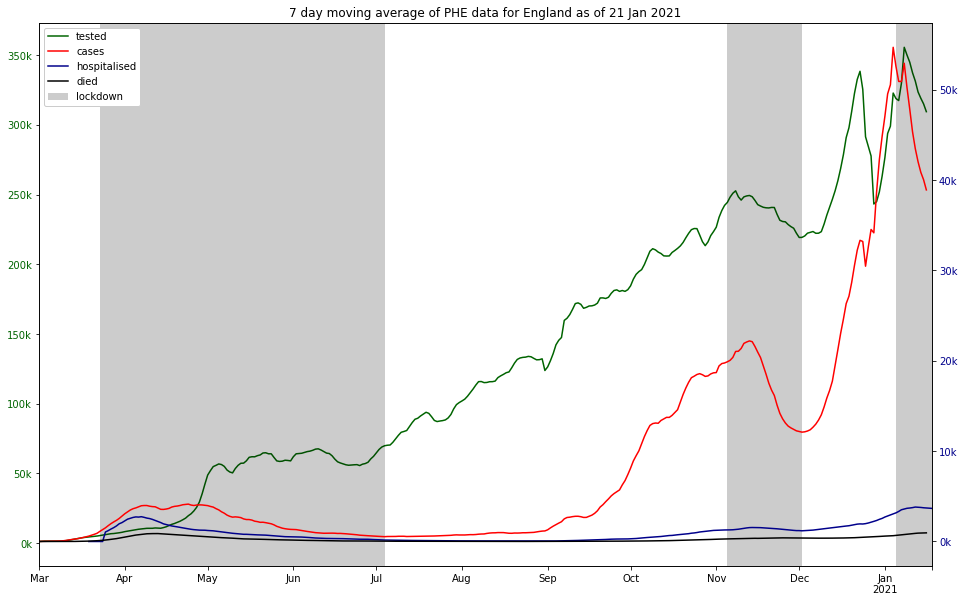

In [37]:
plot_summary(earliest_date='2020-03-01', tested_formatter=lambda y, pos: f"{y / 1_000:,.0f}k")

In [38]:
download('vaccination', 'nation', *vaccination_new_and_weekly, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_2021-01-21.csv')

In [39]:
download('vaccination_cum', 'nation', *vaccination_cumulative, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_cum_2021-01-21.csv')

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,Northern Ireland,N92000002,23073.0,144212.0,121139.0,1893667,1.218430,6.397059,92.384511
1,Scotland,S92000003,4466.0,334871.0,330405.0,5463300,0.081745,6.047718,93.870536
2,Wales,W92000004,396.0,190435.0,190039.0,3152879,0.012560,6.027475,93.959965
3,England,E92000001,436848.0,4303730.0,3866882.0,56286961,0.776109,6.869943,92.353949


'4,973,248'

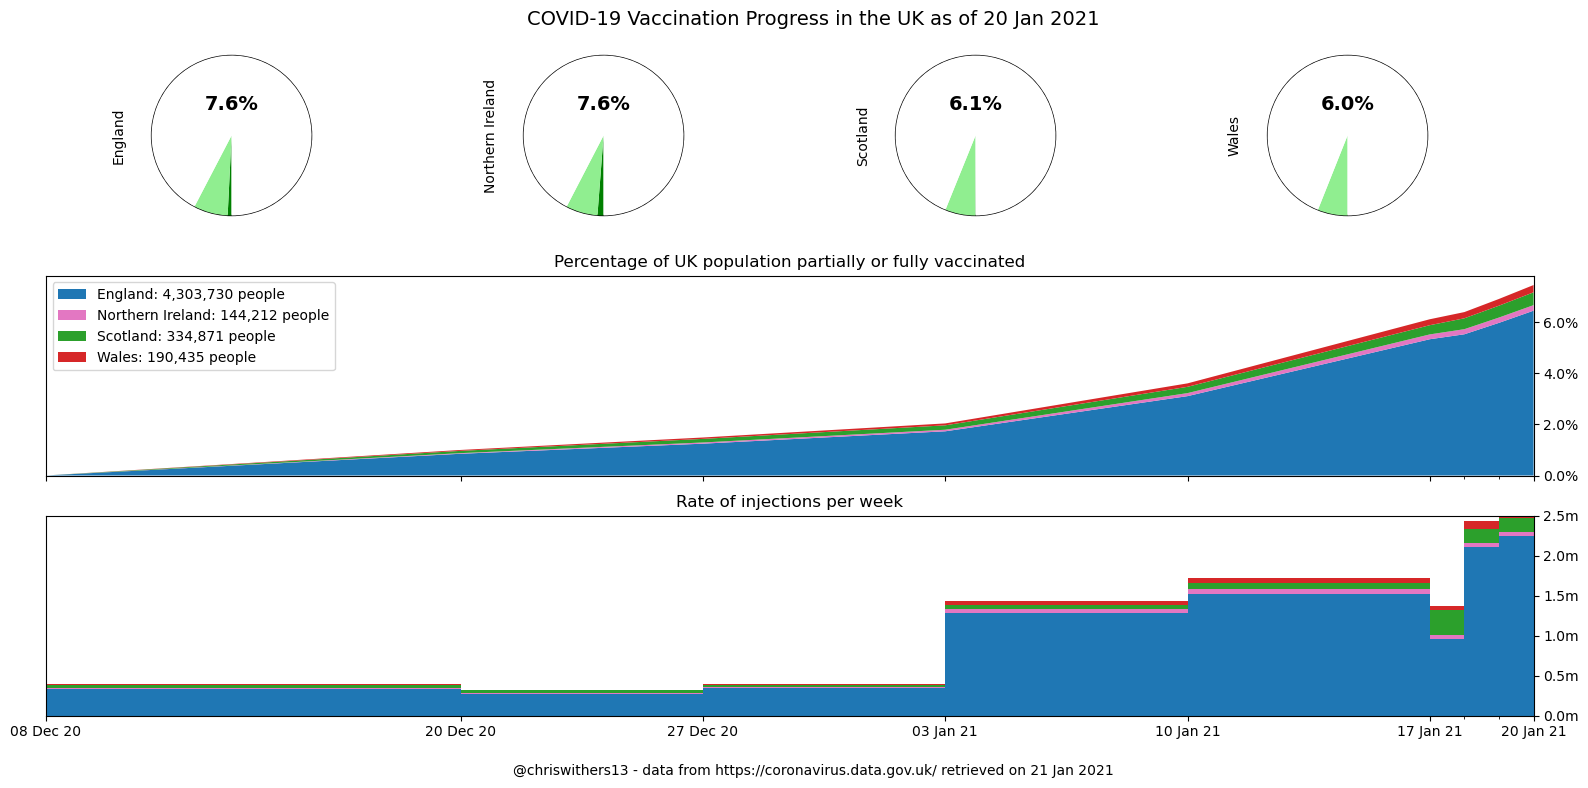

In [2]:
results = vaccination_dashboard()
display(results)
f"{results['any'].sum():,.0f}"

In [41]:
vaccination_corrections()

In [42]:
download(nation, nation, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/nation_2021-01-21.csv')

In [43]:
download(region, region, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/region_2021-01-21.csv')

In [44]:
download(ltla, ltla, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/ltla_2021-01-21.csv')

In [45]:
if is_msoa_data_ready():
    path = download(msoa, msoa, new_cases_sum, new_cases_rate, new_cases_change, 'release', release=release)
    display(path)
    check_path(path)

today: 2021-01-21, release: 2021-01-21 16:11:09.100020+00:00, msoa: 2021-01-21 16:31:02+00:00


PosixPath('/Users/chris/coronavirus/data/msoa_2021-01-21.csv')